<a href="https://colab.research.google.com/github/mimiachiu/Deep-Learning-with-Python-Book/blob/master/Ch08_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keras

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving style.jpg to style.jpg
Saving target.jpg to target.jpg


In [ ]:
#設定圖片路徑與調整高度
from keras.preprocessing.image import load_img, img_to_array

target_image_path = 'target.jpg'
style_reference_image_path = 'style.jpg'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [ ]:
#輔助函式
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deproecess_image(x):
    #將圖片各個channel的像素加上ImageNet的channel平均像素值
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    #將圖片從'BGR'轉換為'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
#載入預先訓練的VGG19神經網路並將其應用於三個圖片
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
print('Model loaded')

Model loaded


In [ ]:
#定義內容損失
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [ ]:
#定義風格損失
#計算格拉姆矩陣
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [ ]:
#總變異損失(用意在於促進生成圖片的空間連續性，從而避免過度像素顆粒化)
def total_variation_loss(x):
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [ ]:
#定義將要最小化的最終損失
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)

layer_features = outputs_dict[content_layer]

target_image_features = layer_features[0, :, :, :]
combination_image_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, combination_image_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
  
loss += total_variation_weight * total_variation_loss(combination_image)

In [ ]:
#設定梯度下降處理程序
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
#以L-BFGS優化器進行梯度下降，進行神經風格轉換
from scipy.optimize import fmin_l_bfgs_b
#from scipy.misc import imsave
import imageio
import time

result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
print(x.shape)
for i in range(iterations):
    print(f'第 {i} 次迭代')
    start_time = time.time()

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    print('目前損失值：', min_val)

    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    #imsave(fname, img)
    imageio.imwrite(fname, img)
    end_time = time.time()
    print(f'圖片以檔名 {fname} 儲存')
    print(f'第 {i} 次迭代所花費的時間:{end_time - start_time}')

(639600,)
第 0 次迭代
目前損失值： 8838268000.0
圖片以檔名 style_transfer_result_at_iteration_0.png 儲存
第 0 次迭代所花費的時間:15.098117351531982
第 1 次迭代
目前損失值： 2750835500.0
圖片以檔名 style_transfer_result_at_iteration_1.png 儲存
第 1 次迭代所花費的時間:14.777453660964966
第 2 次迭代
目前損失值： 1344112500.0
圖片以檔名 style_transfer_result_at_iteration_2.png 儲存
第 2 次迭代所花費的時間:14.982872247695923
第 3 次迭代
目前損失值： 844279000.0
圖片以檔名 style_transfer_result_at_iteration_3.png 儲存
第 3 次迭代所花費的時間:15.174078941345215
第 4 次迭代
目前損失值： 647179400.0
圖片以檔名 style_transfer_result_at_iteration_4.png 儲存
第 4 次迭代所花費的時間:15.20333218574524
第 5 次迭代
目前損失值： 525764100.0
圖片以檔名 style_transfer_result_at_iteration_5.png 儲存
第 5 次迭代所花費的時間:15.245311975479126
第 6 次迭代
目前損失值： 438819680.0
圖片以檔名 style_transfer_result_at_iteration_6.png 儲存
第 6 次迭代所花費的時間:15.387220621109009
第 7 次迭代
目前損失值： 368169630.0
圖片以檔名 style_transfer_result_at_iteration_7.png 儲存
第 7 次迭代所花費的時間:15.33949589729309
第 8 次迭代
目前損失值： 329989820.0
圖片以檔名 style_transfer_result_at_iteration_8.png 儲存
第 8 次迭代所花費的時間:15.29737663269043


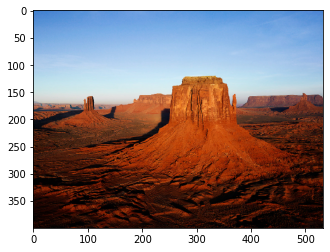

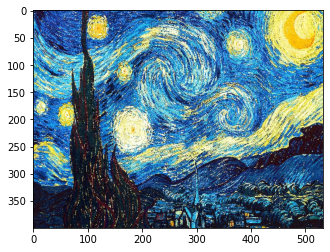

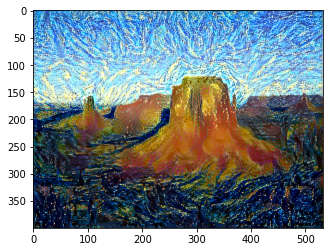

In [ ]:
#顯示神經風轉換圖片
from matplotlib import pyplot as plt

plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(img)
plt.show()